How to make use of the Fourier Transformation to remove image elements

Fourier Transformations (Image by Author)
One of the more advanced topics in image processing has to do with the concept of Fourier Transformation. Put very briefly, some images contain systematic noise that users may want to remove. If such noise is regular enough, employing Fourier Transformation adjustments may aid in image processing. In this article we shall see exactly how to do this.

Let us begin.

As always, start by importing the required Python libraries.

In [34]:
import numpy as np  
import matplotlib.pyplot as plt  
from skimage.io import imread, imshow  
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv  
from skimage import color, exposure, transform  
from skimage.exposure import equalize_hist

Load the Image

In [35]:
dark_image = imread('against_the_light.png')
print(dark_image.shape)

(700, 700, 3)


The image we will be using is the one above. It as image of a street taken when the sun was facing directly at the camera. For this simple exercise we shall try to find a way to eliminate (or least drastically reduce) the powerlines in the back.

As a start, let us convert our image into greyscale.

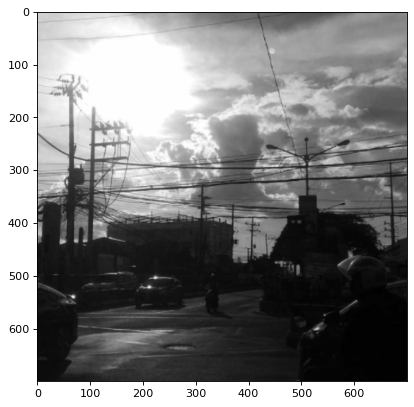

In [36]:
dark_image_grey = rgb2gray(dark_image)  
plt.figure(num=None, figsize=(8, 6), dpi=80)  
plt.imshow(dark_image_grey, cmap='gray');

Excellent, from here we can now easily use the fft function found in Skimage.

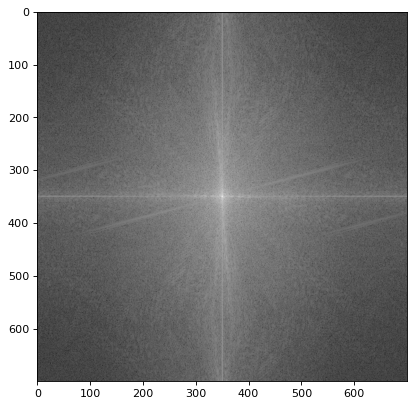

In [37]:
dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(dark_image_grey))
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(np.log(abs(dark_image_grey_fourier)), cmap='gray');

In the image we can see two very clear distortions. The white vertical and horizontal lines refer to the sharp horizontal and vertical elements of the image. Let us see what happens if we mask one of them.

In [65]:
def fourier_masker(image, mask, i):
    f_size = 15
    dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(rgb2gray(image)))
    dark_image_grey_fourier = np.multiply(dark_image_grey_fourier,mask)
    dark_image_grey_fourier[dark_image_grey_fourier==0]=i
    fig, ax = plt.subplots(1,3,figsize=(15,15))
    ax[0].imshow(np.log(abs(dark_image_grey_fourier)), cmap='gray')
    ax[0].set_title('Masked Fourier', fontsize = f_size)
    ax[1].imshow(rgb2gray(image), cmap = 'gray')
    ax[1].set_title('Greyscale Image', fontsize = f_size);
    ax[2].imshow(abs(np.fft.ifft2(dark_image_grey_fourier)), 
                     cmap='gray')
    ax[2].set_title('Transformed Greyscale Image', 
                     fontsize = f_size)

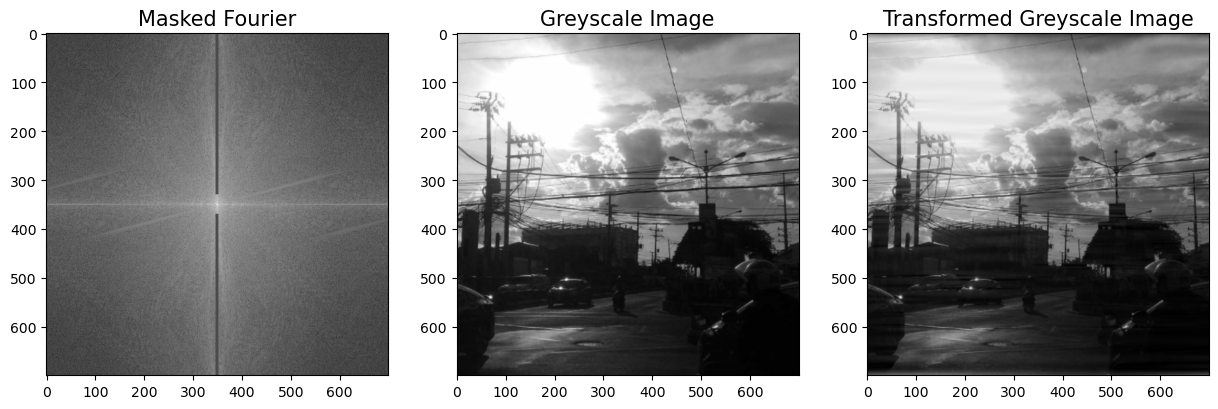

In [66]:
mask=np.ones(dark_image[:,:,0].shape)
mask[0:330,347:353]=0
mask[370:700,347:353]=0
fourier_masker(dark_image,mask, 1)

We can see that the horizontal power cables have significantly reduced in size. As an interesting experiment, let us see what would happen if we masked the horizontal line instead.

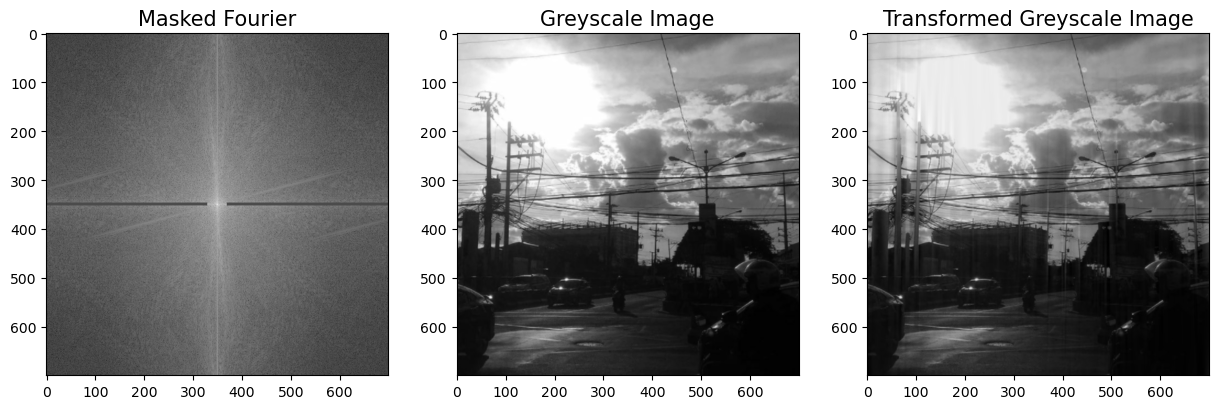

In [67]:
mask=np.ones(dark_image[:,:,0].shape)
mask[347:353,0:330]=0
mask[347:353,370:700]=0
fourier_masker(dark_image,mask, 1)

Lets try high pass and low pass filters

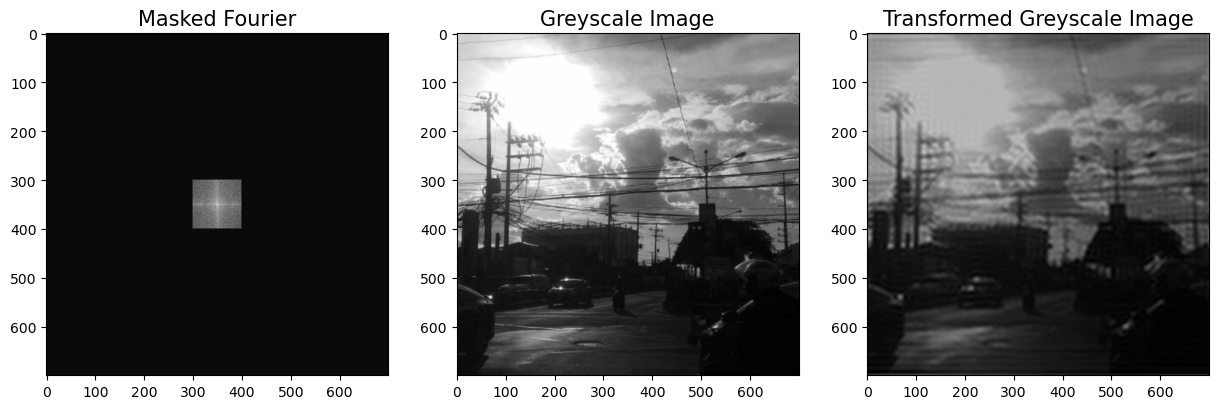

In [69]:
#Low Pass filter
mask=np.zeros(dark_image[:,:,0].shape)
mask[300:400,300:400]=1
fourier_masker(dark_image,mask, 1)

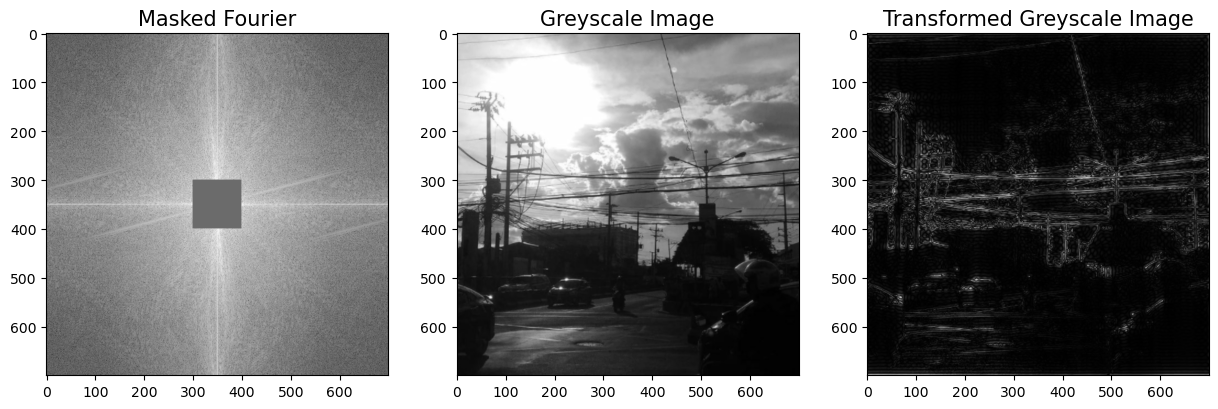

In [70]:
#High Pass filter
mask=np.ones(dark_image[:,:,0].shape)
mask[300:400,300:400]=0
fourier_masker(dark_image,mask, 1)

We can see that all the vertical aspects of the image have been smudged. This is highly noticeable in the electric poles. Though helpful in some settings, this is clearly not helpful in this here.

Though we will stick to masking the Fourier Transformation’s vertical line (again remember that when converted back into the original image this smudges the horizontal lines), let us experiment with different degrees of masking.

In [71]:
mask=np.ones(dark_image[:,:,0].shape)
mask[0:330,347:353]=0
mask[370:700,347:353]=0

def fourier_iterator(image, value_list):
    for i in value_list:
        fourier_masker(dark_image,mask, i)
 
fourier_iterator(dark_image, [0.001, 1, 100])

TypeError: fourier_masker() takes 3 positional arguments but 4 were given

We can see that decreasing the value has almost no effect on the original image, however increasing the value seems to darken original image. As there is practically no difference between the smaller value and 1, let us stick to 1 for simplicity.

Finally, let us enact Fourier Transformation adjustment while retaining the colors of the original image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


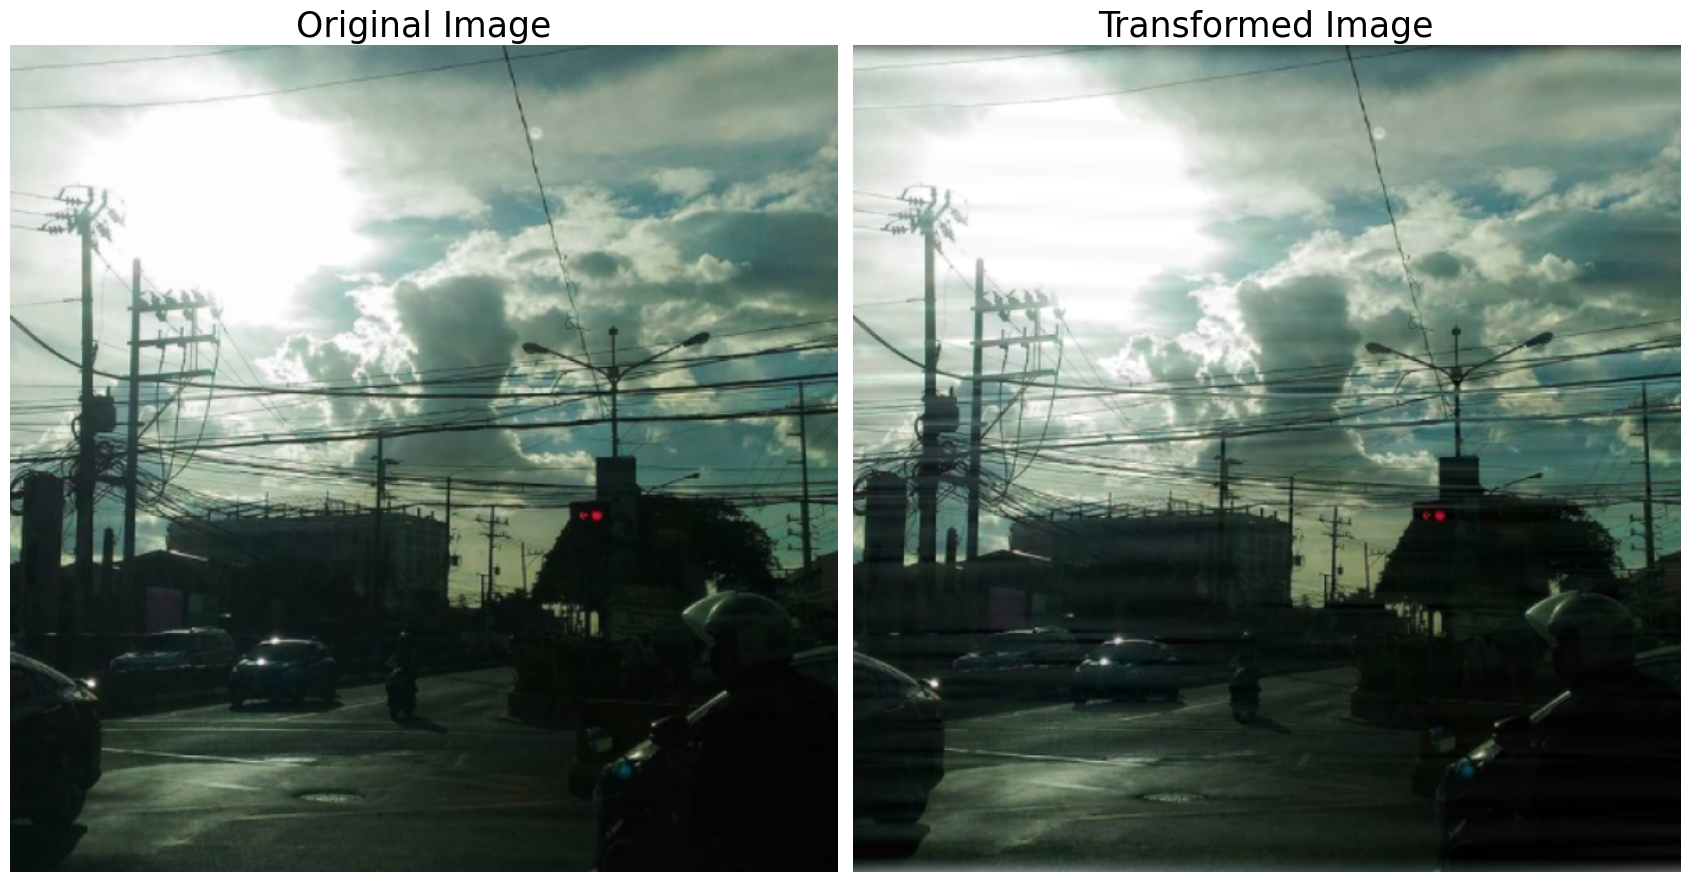

In [39]:
def fourier_transform_rgb(image):
    f_size = 25
    transformed_channels = []
    for i in range(3):
        rgb_fft = np.fft.fftshift(np.fft.fft2((image[:, :, i])))
        rgb_fft[:330, 347:353] = 1
        rgb_fft[-330:,347:353] = 1
        transformed_channels.append(abs(np.fft.ifft2(rgb_fft)))
    
    final_image = np.dstack([transformed_channels[0].astype(int), 
                             transformed_channels[1].astype(int), 
                             transformed_channels[2].astype(int)])
    
    fig, ax = plt.subplots(1, 2, figsize=(17,12))
    ax[0].imshow(image)
    ax[0].set_title('Original Image', fontsize = f_size)
    ax[0].set_axis_off()
    
    ax[1].imshow(final_image)
    ax[1].set_title('Transformed Image', fontsize = f_size)
    ax[1].set_axis_off()
    
    fig.tight_layout()

fourier_transform_rgb(dark_image)


We can see that the horizontal power cables have been greatly reduced while the rest of the image remains mostly intact. This showcases how we can make subtle changes to an image via Fourier Transformation.

In Summary

Fourier Transformation is a powerful tool that can be quite useful for data scientists working with images. In future articles we shall go over how to apply the technique in much more impactful ways. For now, I hope you were able to get a basic grasp of the subject.